In [1]:
!pip install transformers datasets nltk scikit-learn pillow matplotlib tqdm

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import json
from collections import Counter
import nltk
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from transformers import ViTModel, GPT2LMHeadModel, GPT2TokenizerFast, AdamW, get_linear_schedule_with_warmup
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import random

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda


In [3]:
dataset_path = '/kaggle/input/flickr8k'
image_dir = os.path.join(dataset_path, 'Images')
captions_file = os.path.join(dataset_path, "captions.txt")

In [4]:
def load_captions(captions_file):
    """Loads captions from captions.txt (comma-separated), skipping header and removing image extension."""
    mapping = {}
    with open(captions_file, 'r') as f:
        next(f)
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) < 2:
                continue
            img_id, caption_text_list = parts[0], parts[1:]
            img_id = img_id.strip().split('.')[0]
            caption_text = " ".join(caption_text_list).strip()

            if img_id not in mapping:
                mapping[img_id] = []
            mapping[img_id].append(caption_text)
    return mapping


mapping = load_captions(captions_file)
image_ids = list(mapping.keys())
print(f"Total images: {len(image_ids)}")

# Split into train and validation (using provided Flickr 8k splits if available would be better for reproducibility, but for simplicity we'll do a random split here)
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=SEED) # Using a simple split for demonstration
print(f"Train images: {len(train_ids)}, Validation images: {len(val_ids)}")

Total images: 8091
Train images: 6472, Validation images: 1619


In [5]:
from transformers import ViTFeatureExtractor

# GPT-2 Tokenizer and ViT Feature Extractor
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


def preprocess_caption(caption, tokenizer, max_length=50):
    """Tokenizes and preprocesses caption using GPT-2 tokenizer."""
    return tokenizer.encode(caption, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt').squeeze(0)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, caption_mapping, image_ids, tokenizer, feature_extractor, max_length=50):
        self.image_dir = image_dir
        self.caption_mapping = caption_mapping
        self.image_ids = image_ids
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = max_length

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.jpg')
        image = Image.open(image_path).convert('RGB')

        # Image features using ViT Feature Extractor
        image_features = self.feature_extractor(images=image, return_tensors="pt") # Returns BatchFeature
        pixel_values = image_features.pixel_values.squeeze() # Get pixel_values and remove batch dim (will be added by DataLoader)

        # Tokenized caption
        captions = self.caption_mapping[image_id]
        caption_text = random.choice(captions) # Random caption for training
        tokenized_caption = preprocess_caption(caption_text, self.tokenizer, self.max_length)

        return pixel_values, tokenized_caption # Return pixel_values and tokenized caption



In [7]:
# Create Datasets and DataLoaders
train_dataset = Flickr8kDataset(image_dir, mapping, train_ids, tokenizer, feature_extractor)
val_dataset = Flickr8kDataset(image_dir, mapping, val_ids, tokenizer, feature_extractor)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)



In [8]:
from transformers import GPT2Config

class ViT_GPT2_Captioner(nn.Module):
    def __init__(self):
        super(ViT_GPT2_Captioner, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        # Configure GPT-2 for cross-attention
        gpt2_config = GPT2Config.from_pretrained('gpt2') # Get default GPT-2 config
        gpt2_config.add_cross_attention = True # Enable cross-attention
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2', config=gpt2_config) # Load GPT-2 with modified config

        self.bridge = nn.Linear(self.vit.config.hidden_size, self.gpt2.config.n_embd)
        # Freeze ViT
        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, pixel_values, captions, attention_mask=None):
        # ViT encoding
        visual_features = self.vit(pixel_values=pixel_values).last_hidden_state
        projected_features = self.bridge(visual_features[:, 0, :])

        # GPT-2 decoding with cross-attention
        outputs = self.gpt2(input_ids=captions, attention_mask=attention_mask, encoder_hidden_states=projected_features.unsqueeze(1), encoder_attention_mask=torch.ones(projected_features.size(0), 1).to(projected_features.device))
        return outputs.logits

In [9]:
model = ViT_GPT2_Captioner().to(device)
print("Model with Cross-Attention GPT-2 loaded to:", device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model with Cross-Attention GPT-2 loaded to: cuda


In [10]:
# Training parameters
num_epochs = 11
learning_rate = 3e-5
weight_decay = 1e-4
warmup_steps_ratio = 0.1
clip_grad_norm = 1.0

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = len(train_dataloader) * num_epochs
warmup_steps = int(total_steps * warmup_steps_ratio)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
loss_criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)", leave=False)
    for pixel_values, captions in progress_bar: # Get pixel_values and captions directly
        pixel_values = pixel_values.to(device) # Move pixel_values to device
        captions = captions.to(device)
        attention_mask = (captions != tokenizer.pad_token_id).long().to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values, captions[:, :-1], attention_mask[:, :-1]) # Pass pixel_values directly
        logits = outputs
        loss = loss_criterion(logits.view(-1, logits.size(-1)), captions[:, 1:].reshape(-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': total_loss / (progress_bar.n + 1)})

    avg_train_loss = total_loss / len(train_dataloader)

    model.eval()
    val_loss = 0.0
    val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)", leave=False)
    with torch.no_grad():
        for pixel_values, captions in val_progress_bar: # Get pixel_values and captions directly
            pixel_values = pixel_values.to(device) # Move pixel_values to device
            captions = captions.to(device)
            attention_mask = (captions != tokenizer.pad_token_id).long().to(device)

            outputs = model(pixel_values, captions[:, :-1], attention_mask[:, :-1]) # Pass pixel_values directly
            logits = outputs
            loss = loss_criterion(logits.view(-1, logits.size(-1)), captions[:, 1:].reshape(-1))
            val_loss += loss.item()
            val_progress_bar.set_postfix({'val_loss': val_loss / (val_progress_bar.n + 1)})

    avg_val_loss = val_loss / len(val_dataloader)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model_vit_gpt2.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after epoch {epoch+1}!")
        break

print("Training finished!")
print(f"Best validation loss: {best_val_loss:.4f}")

Epoch 1/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 1/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 1: Train Loss: 3.9198, Val Loss: 3.2181


Epoch 2/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 2/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 2: Train Loss: 3.1998, Val Loss: 2.9764


Epoch 3/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 3/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 3: Train Loss: 3.0305, Val Loss: 2.9091


Epoch 4/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 4/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 4: Train Loss: 2.9231, Val Loss: 2.8406


Epoch 5/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 5/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 5: Train Loss: 2.8705, Val Loss: 2.7621


Epoch 6/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 6/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 6: Train Loss: 2.7979, Val Loss: 2.7275


Epoch 7/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 7/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 7: Train Loss: 2.7629, Val Loss: 2.7206


Epoch 8/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 8/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 8: Train Loss: 2.7325, Val Loss: 2.6985


Epoch 9/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 9/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 9: Train Loss: 2.7033, Val Loss: 2.6996


Epoch 10/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 10/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 10: Train Loss: 2.6891, Val Loss: 2.6862


Epoch 11/11 (Training):   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 11/11 (Validation):   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 11: Train Loss: 2.6832, Val Loss: 2.6792
Training finished!
Best validation loss: 2.6792


In [12]:
def evaluate_bleu(model, dataloader, tokenizer, device, max_gen_len=20):
    model.eval()
    references = []
    hypotheses = []
    with torch.no_grad():
        for pixel_values, captions in tqdm(dataloader, desc="Evaluating BLEU"):
            pixel_values = pixel_values.to(device)
            captions = captions.to(device)
            generated_tokens = generate_caption(model, pixel_values, tokenizer, device, max_len=max_gen_len)
            predicted_caption = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            real_captions = [tokenizer.batch_decode([cap], skip_special_tokens=True) for cap in captions]

            hypotheses.extend(predicted_caption)
            references.extend(real_captions)

    smoothing = SmoothingFunction() # Instantiate SmoothingFunction
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=smoothing.method1)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing.method1)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing.method1)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing.method1)
    return bleu1, bleu2, bleu3, bleu4

In [13]:
def generate_caption(model, pixel_values, tokenizer, device, max_len=20):
    model.eval()
    batch_size = pixel_values.size(0)
    input_ids = torch.full((batch_size, 1), tokenizer.eos_token_id, dtype=torch.long, device=device) # GPT-2 EOS token as start

    for _ in range(max_len):
        attention_mask = torch.ones_like(input_ids).to(device)
        outputs = model(pixel_values, input_ids, attention_mask)
        predicted_token_logits = outputs[:, -1, :]
        _, next_token = torch.max(predicted_token_logits, dim=-1)
        next_token = next_token.unsqueeze(1)
        input_ids = torch.cat((input_ids, next_token), dim=-1)
    return input_ids

In [14]:
best_model_path = 'best_model_vit_gpt2.pth'
model.load_state_dict(torch.load(best_model_path))
val_bleu1, val_bleu2, val_bleu3, val_bleu4 = evaluate_bleu(model, val_dataloader, tokenizer, device)
print(f"Validation BLEU-1: {val_bleu1:.4f}")
print(f"Validation BLEU-2: {val_bleu2:.4f}")
print(f"Validation BLEU-3: {val_bleu3:.4f}")
print(f"Validation BLEU-4: {val_bleu4:.4f}")


<ipython-input-14-442ff05a1f2f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Evaluating BLEU:   0%|          | 0/51 [00:00<?, ?it/s]

Validation BLEU-1: 0.5591
Validation BLEU-2: 0.4205
Validation BLEU-3: 0.3162
Validation BLEU-4: 0.2430


In [15]:
def generate_caption_for_image(model, image_path, tokenizer, device, feature_extractor, max_gen_len=20):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_features = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device) # Move feature extraction to device

    generated_tokens = generate_caption(model, image_features, tokenizer, device, max_len=max_gen_len)
    caption = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    return caption

In [16]:
sample_image_path = os.path.join(image_dir, val_ids[10] + '.jpg')
generated_caption = generate_caption_for_image(model, sample_image_path, tokenizer, device, feature_extractor)

print(f"Sample Image: {sample_image_path}")
print(f"Generated Caption: {generated_caption}")

Sample Image: /kaggle/input/flickr8k/Images/3676561090_9828a9f6d0.jpg
Generated Caption: A dog is running through a field . . . and a man is standing behind him . . .


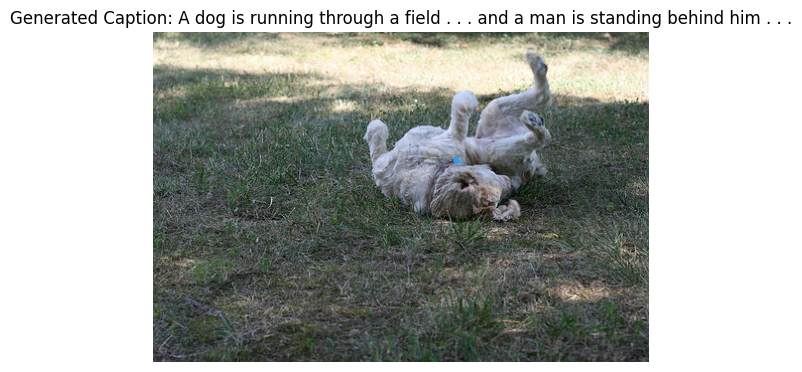

In [17]:
img = Image.open(sample_image_path)
plt.imshow(img)
plt.title("Generated Caption: " + generated_caption)
plt.axis('off')
plt.show()


In [18]:
# Saving Model
#output_dir = "vit-gpt2-flickr8k-image-captioner"
#os.makedirs(output_dir, exist_ok=True)
#model.save_pretrained(os.path.join(output_dir, "model"))
#tokenizer.save_pretrained(os.path.join(output_dir, "tokenizer"))
#feature_extractor.save_pretrained(os.path.join(output_dir, "feature_extractor"))
#print(f"Model saved to: {output_dir}")

In [19]:
!pip install huggingface_hub

In [20]:
# Login to Hugging Face Hub with your token using Kaggle Secrets
from huggingface_hub import HfApi, login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
huggingface_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")

if huggingface_token:
    login(token=huggingface_token)
    print("Login successful using Kaggle Secret!")
else:
    print("Hugging Face token not found in Kaggle Secrets. Please add it to Kaggle Secrets with label 'HUGGINGFACE_TOKEN'.")
    print("Deployment to Hugging Face Hub will likely fail without login.")
    # uncomment the next line for manual login if you prefer (less secure in notebooks)
    # login()


Login successful using Kaggle Secret!


In [21]:
# Define output directory for saving model locally
output_dir = "vit-gpt2-flickr8k-image-captioner"
os.makedirs(output_dir, exist_ok=True)

# Save model, tokenizer, and feature extractor locally
#model.save_pretrained(os.path.join(output_dir, "model"))
torch.save(model.state_dict(), os.path.join(output_dir, "model.pth")) # Save model state_dict using torch.save
tokenizer.save_pretrained(os.path.join(output_dir, "tokenizer"))
feature_extractor.save_pretrained(os.path.join(output_dir, "feature_extractor"))

print(f"Model, tokenizer, and feature extractor saved locally to: {output_dir}")

# Push to Hugging Face Hub
api = HfApi()
repo_id = "ayushrupapara/vit-gpt2-flickr8k-image-captioner" # Replace with your username and desired repo name

api.create_repo(repo_id, repo_type="model", exist_ok=True) # Create repo if it doesn't exist, or use existing

try:
    api.upload_folder(
        folder_path=output_dir,
        repo_id=repo_id,
        repo_type="model"
    )
    print(f"Model pushed to Hugging Face Hub: https://huggingface.co/{repo_id}")
except Exception as e:
    print(f"Error pushing to Hugging Face Hub: {e}")
    print("Make sure you are logged in and have the correct repo ID.")

Model, tokenizer, and feature extractor saved locally to: vit-gpt2-flickr8k-image-captioner


model.pth:   0%|          | 0.00/959M [00:00<?, ?B/s]

Model pushed to Hugging Face Hub: https://huggingface.co/ayushrupapara/vit-gpt2-flickr8k-image-captioner
